In [1]:
import sys

In [2]:
sys.executable

'C:\\Users\\DominiqueFournier\\Anaconda3\\python.exe'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from discretize.utils import meshutils
from SimPEG import Mesh
from SimPEG import Utils
from SimPEG import Maps
from SimPEG import Regularization
from SimPEG import DataMisfit
from SimPEG import Optimization
from SimPEG import InvProblem
from SimPEG import Directives
from SimPEG import Inversion
from SimPEG import PF

**SumMap Demo**

In this notebook, we demonstrate how to use the SumMap. The example uses 

In [4]:
mesh.vectorCCz



NameError: name 'mesh' is not defined

In [5]:
H0 = (50000, 90, 0)

# Create a mesh
dx = 2.5

# Create and array of observation points
xr = np.linspace(-30.5, 30.5, 40)
yr = np.linspace(-20.5, 20.5, 40)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.zeros_like(X) + 2.5 #-np.exp((X**2 + Y**2) / 75**2) + mesh.vectorNz[-1] + 5.

# Create a MAGsurvey
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rx = PF.BaseMag.RxObs(rxLoc)
srcField = PF.BaseMag.SrcField([rx], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField)

# hxind = [(dx, 5, -1.3), (dx, 20), (dx, 5, 1.3)]
# hyind = [(dx, 5, -1.3), (dx, 40), (dx, 5, 1.3)]
# hzind = [(dx, 5, -1.3), (dx, 20)]

# mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CC0')
# mesh.x0 = mesh.x0 - np.r_[0,0,mesh.gridN[-1,2]]

# Create a mesh
h = [5., 5., 5.]
padDist = np.ones((3,2)) * 100
octree_levels=[8, 4, 4]

# Create a topography
mesh = meshutils.mesh_builder_xyz(rxLoc, h, padding_distance=padDist,
                                    mesh_type='TREE',
                                    )

# Refine the mesh around topography
mesh = meshutils.refine_tree_xyz(mesh, rxLoc, method='surface',
                                   octree_levels=octree_levels, finalize=True)


# Get index of the center
midx = int(np.searchsorted(mesh.vectorCCx, 0))
midy = int(np.searchsorted(mesh.vectorCCy, 0))
midz = int(np.searchsorted(mesh.vectorCCz, -10))
# Lets create a simple Gaussian topo and set the active cells
# [xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
# zz = -np.exp((xx**2 + yy**2) / 75**2) + mesh.vectorNz[-1]

# We would usually load a topofile
# topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Go from topo to actv cells
# actv = Utils.surface2ind_topo(mesh, topo, 'N')
# actv = np.asarray([inds for inds, elem in enumerate(actv, 1) if elem],
#                   dtype=int) - 1
actv = mesh.gridCC[:,2] < 0

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = int(actv.sum())




# We can now create a susceptibility model and generate data
model = np.zeros(mesh.nC)

# Add a block in half-space
model = Utils.ModelBuilder.addBlock(mesh.gridCC, model, np.r_[-30,-10,-20], np.r_[-10,10,-10], 0.05)
model = Utils.ModelBuilder.addBlock(mesh.gridCC, model, np.r_[10,-10,-20], np.r_[30,10,-10], 0.05)
model = Utils.ModelBuilder.addBlock(mesh.gridCC, model, np.r_[40,40,-70], np.r_[120,120,50], 0.2)

model = Utils.mkvc(model)
model = model[actv]




In [6]:
def plot_panels(m):
    ypanel = midx
    zpanel = midz

    m_lp = actvMap * m
    m_lp[m_lp == -100] = np.nan

    # # Plot the data
    # PF.Magnetics.plot_obs_2D(rxLoc, d=d)

    fig = plt.figure(figsize=(10,4))

    # Plot Lp model
    ax = plt.subplot(121)
    im = mesh.plotSlice(m_lp, ax=ax, normal='Z', ind=zpanel,
                   grid=True, clim=(m.min(), m.max()))
    plt.plot(([mesh.vectorCCx[0], mesh.vectorCCx[-1]]),
             ([mesh.vectorCCy[ypanel], mesh.vectorCCy[ypanel]]), color='w')
#     plt.title('Plan lp-model.')
    plt.gca().set_aspect('equal')
    plt.colorbar(im[0])
    ax.xaxis.set_visible(False)
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')

    # Vertical section
    ax = plt.subplot(122)
    mesh.plotSlice(m_lp, ax=ax, normal='Y', ind=midx,
                   grid=True, clim=(m.min(), m.max()))
    plt.plot(([mesh.vectorCCx[0], mesh.vectorCCx[-1]]),
             ([mesh.vectorCCz[zpanel], mesh.vectorCCz[zpanel]]), color='w')
#     plt.title('E-W lp-model.')
    plt.gca().set_aspect('equal')
    ax.xaxis.set_visible(False)
    plt.ylabel('z')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()
    
    return fig

In [7]:
midz



29

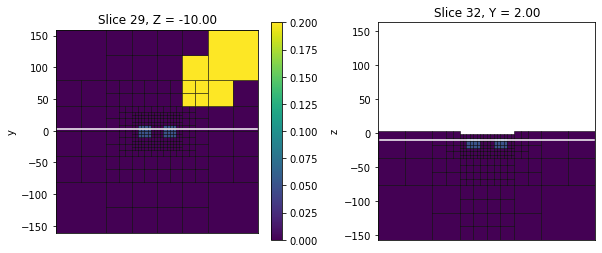

In [8]:
fig = plot_panels(model)
fig.savefig("TrueModel.png")

Begin forward: M=H0, Rx type= tmi
DASK: 
Tile size (nD, nC):  (1600, 2108)
Number of chunks:  1  x  1  =  1
Target chunk size:  128MiB
Max chunk size (GB):  0.0269824
Max RAM (GB x CPU):  0.2158592
Tile size (GB):  0.0269824
Zarr file detected with wrong shape and chunksize ... over-writing
Saving G to zarr: ./sensitivity.zarr
[########################################] | 100% Completed |  6.7s


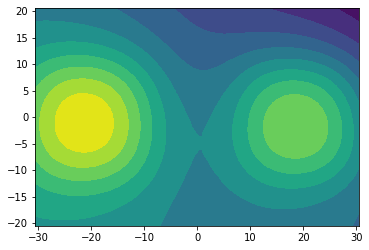

In [9]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv, parallelized='dask')

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
d = prob.fields(model)

# Add noise and uncertainties
# We add some random Gaussian noise (1nT)
data = d + np.random.randn(len(d))
wd = np.ones(len(data))*1.  # Assign flat uncertainties

survey.dobs = data
survey.std = wd
survey.mtrue = model

# Plot the data
rxLoc = survey.srcField.rxList[0].locs
Utils.plot2Ddata(rxLoc, d)
plt.show()

In [19]:
# Divide the problem into two halves
index1 = rxLoc[:,1]>0
rxLoc1 = rxLoc[index1,:]
rx = PF.BaseMag.RxObs(rxLoc1)
srcField = PF.BaseMag.SrcField([rx], param=H0)
survey1 = PF.BaseMag.LinearSurvey(srcField)
survey1.dobs = survey.dobs[index1]
survey1.index = index1


# Create a topography
mesh1 = meshutils.mesh_builder_xyz(rxLoc, h, padding_distance=padDist,
                                    mesh_type='TREE', base_mesh = mesh,
                                    )

# Refine the mesh around topography
mesh1 = meshutils.refine_tree_xyz(mesh1, rxLoc1, method='surface',
                                   octree_levels=octree_levels, finalize=True)


actv1 = mesh1.gridCC[:,2] < 0
# Create the forward model operator
# Create reduced identity map

tileMap1 = Maps.Tile((mesh, actv), (mesh1, actv1))
prob1 = PF.Magnetics.MagneticIntegral(mesh1, chiMap=tileMap1, actInd=actv1)

# Pair the survey and problem
survey1.pair(prob1)
wr1 = prob1.getJtJdiag(np.ones(int(actv1.sum())))**0.5



# # Create second local problem
# mesh2 = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')
# mesh2.x0 = np.r_[mesh2.x0[0], mesh2.x0[1]-10, mesh2.x0[2]]

index2 = rxLoc[:,1]<=0
rxLoc2 = rxLoc[index2,:]
rx = PF.BaseMag.RxObs(rxLoc2)
srcField = PF.BaseMag.SrcField([rx], param=H0)
survey2 = PF.BaseMag.LinearSurvey(srcField)
survey2.dobs = survey.dobs[index2]
survey2.index = index2

# Create a topography
mesh2 = meshutils.mesh_builder_xyz(rxLoc, h, padding_distance=padDist,
                                    mesh_type='TREE', base_mesh = mesh,
                                    )

# Refine the mesh around topography
mesh2 = meshutils.refine_tree_xyz(mesh2, rxLoc2, method='surface',
                                   octree_levels=octree_levels, finalize=True)

actv2 = mesh2.gridCC[:,2] < 0
# Create the forward model operator
tileMap2 = Maps.Tile((mesh, actv), (mesh2, actv2))
prob2 = PF.Magnetics.MagneticIntegral(mesh2, chiMap=tileMap2, actInd=actv2)

# Pair the survey and problem
survey2.pair(prob2)
wr2 = prob2.getJtJdiag(np.ones(int(actv2.sum())))**0.5




C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Props.py:426: UserWarning: Model of len(1210) incorrect shape for mappings: 
    chiMap: expected model of len(2108) for Tile(1210,2108)
  '\n    '.join(errors)


Begin forward: M=H0, Rx type= tmi
DASK: 
Tile size (nD, nC):  (800, 1210)
Number of chunks:  1  x  1  =  1
Target chunk size:  128MiB
Max chunk size (GB):  0.007744000000000001
Max RAM (GB x CPU):  0.06195200000000001
Tile size (GB):  0.007744000000000001
Zarr file detected with same shape and chunksize ... re-loading
Begin forward: M=H0, Rx type= tmi
DASK: 
Tile size (nD, nC):  (800, 1210)
Number of chunks:  1  x  1  =  1
Target chunk size:  128MiB
Max chunk size (GB):  0.007744000000000001
Max RAM (GB x CPU):  0.06195200000000001
Tile size (GB):  0.007744000000000001
Zarr file detected with same shape and chunksize ... re-loading


In [20]:
actv.sum(), actv1.sum()







(2108, 1210)

In [24]:
# J1 = np.abs(prob1.G[0,:]*prob1.chiMap.deriv(None))+1e-3
actvMap = Maps.InjectActiveCells(mesh, actv, 1e-8)
# J = np.abs(prob.G[200,:])
# mesh.writeModelUBC('J1.dat',wr)
mesh.writeUBC('Mesh.msh', models={'Wr1.dat':actvMap * wr1})


In [8]:
# Create combo misfit
dmis1 = DataMisfit.l2_DataMisfit(survey1)
dmis1.W = np.ones(survey1.nD)

dmis2 = DataMisfit.l2_DataMisfit(survey2)
dmis2.W = np.ones(survey2.nD)

globalMisfit = dmis1 + dmis2

wr /= wr.max()
wr **= 0.5


SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [9]:
actvMap1 = Maps.InjectActiveCells(mesh1, actv1, 0)
actvMap2 = Maps.InjectActiveCells(mesh2, actv2, 0)


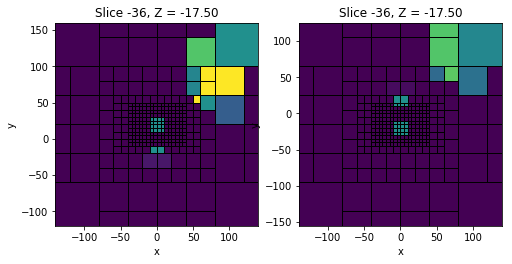

In [10]:
plt.figure(figsize=(8,8))
axs = plt.subplot(1,2,1)
mesh1.plotSlice(actvMap1*tileMap1*model, normal='Z', ind = -36,grid=True, ax=axs, clim=[0, 0.1])
axs.set_xlim([mesh1.gridCC[:,0].min(),mesh1.gridCC[:,0].max()])
axs.set_ylim([mesh1.gridCC[:,1].min(),mesh1.gridCC[:,1].max()])
axs.set_aspect('equal')


axs = plt.subplot(1,2,2)
mesh2.plotSlice(actvMap2*tileMap2*model, normal='Z', ind = -36,grid=True, ax=axs, clim=[0, 0.1])
axs.set_xlim([mesh2.gridCC[:,0].min(),mesh2.gridCC[:,0].max()])
axs.set_ylim([mesh2.gridCC[:,1].min(),mesh2.gridCC[:,1].max()])
axs.set_aspect('equal')
plt.show()


In [11]:
from scipy.spatial import cKDTree
tree = cKDTree(mesh.gridCC[actv,:])
r, ind = tree.query(mesh2.gridCC[actv2])
local2Global = np.c_[np.where(actv2)[0], ind]

tree = cKDTree(mesh2.gridCC[actv2,:])
r, ind = tree.query(mesh.gridCC[actv])
global2Local = np.c_[np.where(actv)[0], ind]

full = np.unique(np.vstack([local2Global, global2Local[:,[1,0]]]), axis=0)
print(local2Global.shape)
print(global2Local.shape)
print(full.shape)
# (mesh, actv), (mesh2, actv2)

(1712, 2)
(9000, 2)
(9222, 2)


In [12]:

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr
# reg.norms = [0, 1, 1, 1]
# reg.eps_p, reg.eps_q = 1e-3, 1e-3


# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(globalMisfit, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, betaest, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.67e+09  1.26e+06  0.00e+00  1.26e+06    7.52e+01      0              
   1  4.33e+09  1.00e+06  1.19e-05  1.05e+06    7.71e+01      0              
   2  2.17e+09  8.30e+05  4.03e-05  9.17e+05    7.57e+01      0   Skip BFGS  
   3  1.08e+09  6.35e+05  1.06e-04  7.49e+05    7.47e+01      0   Skip BFGS  
   4  5.42e+08  4.48e+05  2.29e-04  5.72e+05    7.42e+01      0   Skip BFGS  
   5  2.71e+08  3.03e+05  4.18e-04  4.16e+05    7.32e+01      0   Skip BFGS  
   6  1.35e+08  1.98e+05  6.94e-04  2.92e+05    7.16e+01      0   Skip BFGS  
   7  6.77e+07  1.19e+05  1.11e-03  1.94e+05    7.00e+01      0   Skip BFGS  
   8

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:915: RuntimeWarning: divide by zero encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


  18  6.61e+04  1.97e+02  4.65e-03  5.05e+02    7.18e+01      3   Skip BFGS  
  19  6.61e+04  1.97e+02  4.64e-03  5.04e+02    6.92e+01      2   Skip BFGS  
delta phim: 8.819e-02
  20  6.61e+04  1.97e+02  4.64e-03  5.03e+02    6.59e+01      5   Skip BFGS  
  21  6.61e+04  1.94e+02  4.65e-03  5.01e+02    5.36e+01      2   Skip BFGS  
  22  6.61e+04  1.94e+02  4.65e-03  5.01e+02    5.36e+01      6   Skip BFGS  
delta phim: 1.172e-02
  23  6.61e+04  1.90e+02  4.65e-03  4.98e+02    6.59e+01      3              
Beta search step
  23  1.03e+05  1.90e+02  4.65e-03  6.72e+02    6.57e+01      0   Skip BFGS  
Beta search step
  23  1.61e+05  1.90e+02  4.65e-03  9.42e+02    6.53e+01      0   Skip BFGS  
  24  1.61e+05  1.85e+02  4.65e-03  9.35e+02    7.24e+01      0              
  25  1.61e+05  1.84e+02  4.65e-03  9.34e+02    5.43e+01      3              
------------------------------------------------------------------
0 :    ft     = 9.3372e+02 <= alp*descent     = 9.3372e+02
1 : maxIterLS = 

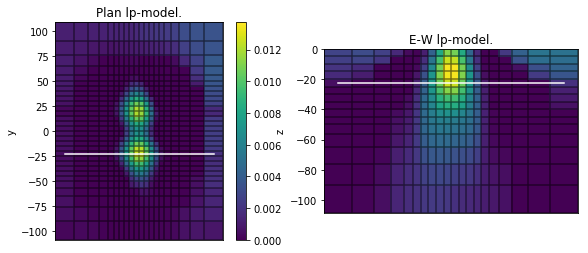

In [13]:
fig = plot_panels(invProb.model)
fig.savefig("Tiled.png")

In [14]:
dpred = np.zeros(survey.nD)
for ind, dmis in enumerate(globalMisfit.objfcts):
    dpred[dmis.survey.index] += dmis.survey.dpred(mrec)

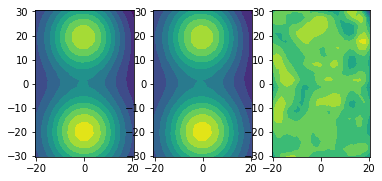

In [15]:
ax = plt.subplot(1,3,1)
Utils.plot2Ddata(rxLoc, d, ax=ax)

ax = plt.subplot(1,3,2)
Utils.plot2Ddata(rxLoc, dpred, ax=ax)

ax = plt.subplot(1,3,3)
Utils.plot2Ddata(rxLoc, d-dpred, ax=ax)

plt.show()


Re-run the problem in one shot

In [16]:
wr = np.sum(prob.G**2., axis=0)**0.5
wr /= wr.max()

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr

# Create misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = np.ones(survey.nD)

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, betaest, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.11e+10  1.25e+06  0.00e+00  1.25e+06    7.60e+01      0              
   1  5.55e+09  1.05e+06  7.75e-06  1.10e+06    7.80e+01      0              
   2  2.78e+09  9.13e+05  2.63e-05  9.86e+05    7.62e+01      0   Skip BFGS  
   3  1.39e+09  7.28e+05  7.49e-05  8.32e+05    7.55e+01      0   Skip BFGS  
   4  6.94e+08  5.27e+05  1.79e-04  6.51e+05    7.50e+01      0   Skip BFGS  
   5  3.47e+08  3.56e+05  3.54e-04  4.79e+05    7.42e+01      0   Skip BFGS  
   6  1.73e+08  2.32e+05  6.08e-04  3.37e+05    7.30e+01      0   Skip BFGS  
   7  8.6

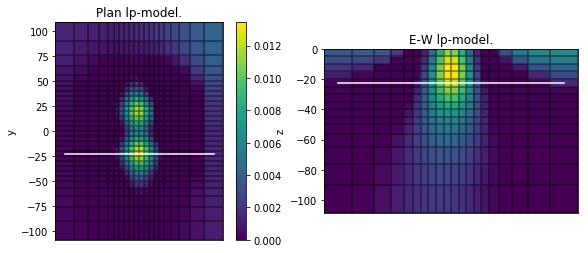

In [17]:
fig = plot_panels(mrec)
fig.savefig("Conventional.png")

In [6]:
# dmis = DataMisfit.l2_DataMisfit(survey)

# # Create multiple problems with shared G
# combo = dmis

# for ii in range(10):
    
#     surveyTile = PF.BaseMag.LinearSurvey(srcField)
#     # Create the forward model operator
#     probTile = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv, parallelized=True)

#     # Pair the survey and problem
#     surveyTile.pair(probTile)

#     if ii > 0:
#         probTile._G = dmis.prob.G
#     # Compute linear forward operator and compute some data
#     d = probTile.fields(model)
#     surveyTile.dobs=d
#     dmis = DataMisfit.l2_DataMisfit(surveyTile)
    
#     print("Prob" + str(ii))
#     combo += dmis


SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Begin forward: M=H0, Rx type= tmi
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob0
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob1
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob2
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob3
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob4
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob5
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob6
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob7
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob8
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Prob9


In [32]:
del combo
